In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import numpy as np
import pandas as pd
import optuna
import os
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv
/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


In [2]:
train = pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [3]:
train.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
print('Number of rows: {}, Number of columns = {}'.format(train.shape[0], train.shape[1]))

Number of rows: 7043, Number of columns = 21


In [5]:
train.MonthlyCharges.value_counts()[train.MonthlyCharges.value_counts().index < 19]

18.80    7
18.95    6
18.85    5
18.70    2
18.90    2
18.25    1
18.75    1
18.55    1
18.40    1
Name: MonthlyCharges, dtype: int64

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
type(train.TotalCharges[0])
train.TotalCharges = train.TotalCharges.replace(' ', None)
train.TotalCharges = train.TotalCharges.apply(lambda x: float(eval(x)))
train.SeniorCitizen.value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

In [8]:
train.tenure.value_counts()

1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: tenure, Length: 73, dtype: int64

In [9]:
train.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

### Outliers Detection

There are many methods that can be used to detect outliers in a dataset. In this workshop we will discuss the following:
* Box Plot method
* Standarization (Z-sore) method

##### Box Plot :: Consists of five main components:
* Q1, first quartile (Midean of the first half of the data)
* Q2, Midean of the data
* Q3, midean of the second half of the data
* Max value
* Min value

##### Main equations in box plots:
$$ IQR = Q3 - Q1 $$
$$ Outliers = Q3 + 1.5 * IQR$$
$$ Q1 - 1.5 * IQR $$

##### Z-score method
Z-score represents the number of standard deviations removed from the mean for each data point. In a simpler way, it is the distance for a point from the mean in standard deviations.
$$ z-score = {x - mean \over std} $$

<AxesSubplot:>

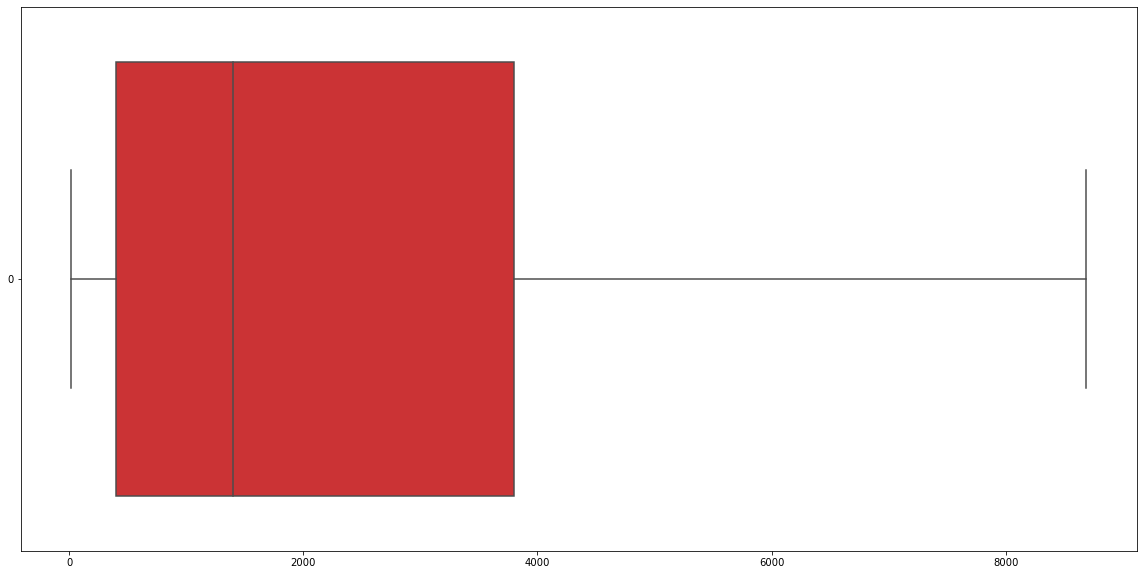

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (20,10))
ax = fig.gca()
sns.boxplot(data= train['TotalCharges'], orient="h", palette="Set1", ax = ax)

<AxesSubplot:>

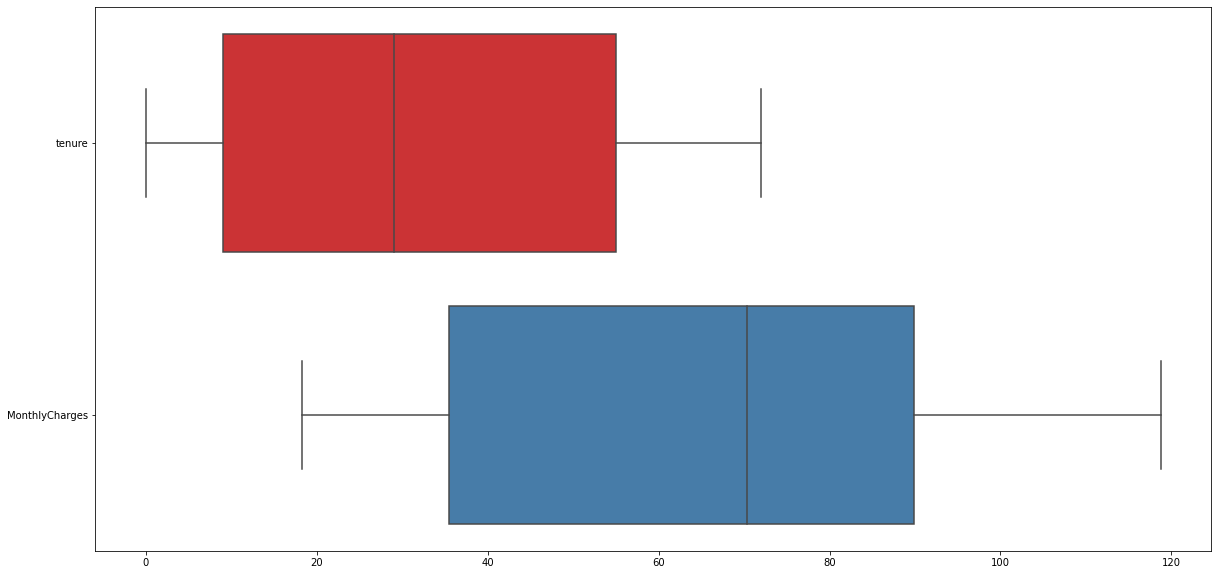

In [11]:
fig = plt.figure(figsize = (20,10))
ax = fig.gca()
sns.boxplot(data= train[['tenure', 'MonthlyCharges']], orient="h", palette="Set1", ax = ax)

In [12]:
from scipy import stats

rows = np.any(stats.zscore(train[['tenure', 'MonthlyCharges', 'TotalCharges']].values) > 2.5, axis=1)
outliers = train.loc[rows]
outliers.shape

(89, 21)

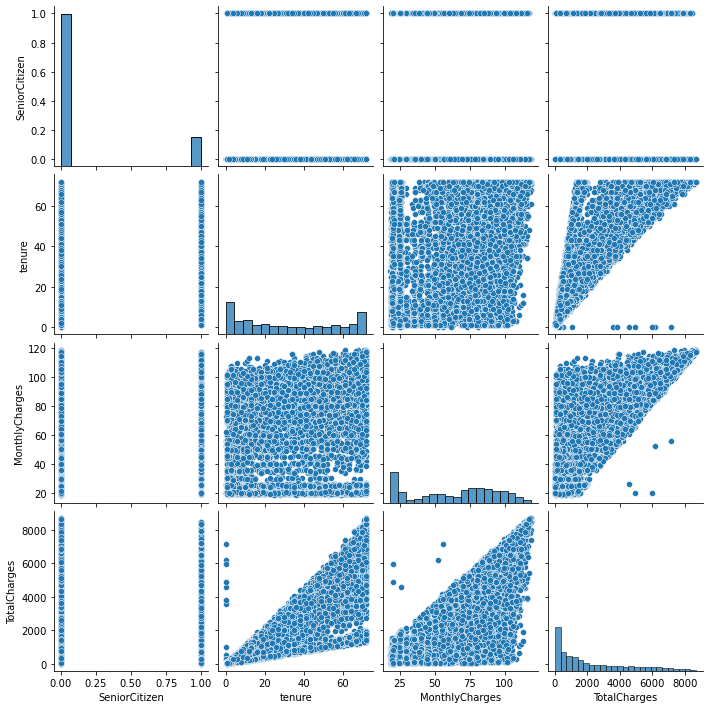

In [13]:
sns.pairplot(train)

<AxesSubplot:>

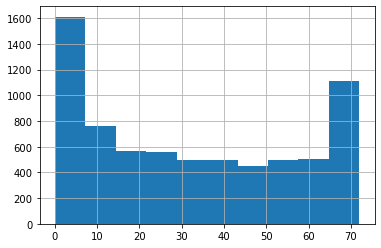

In [14]:
train.tenure.hist()

<AxesSubplot:>

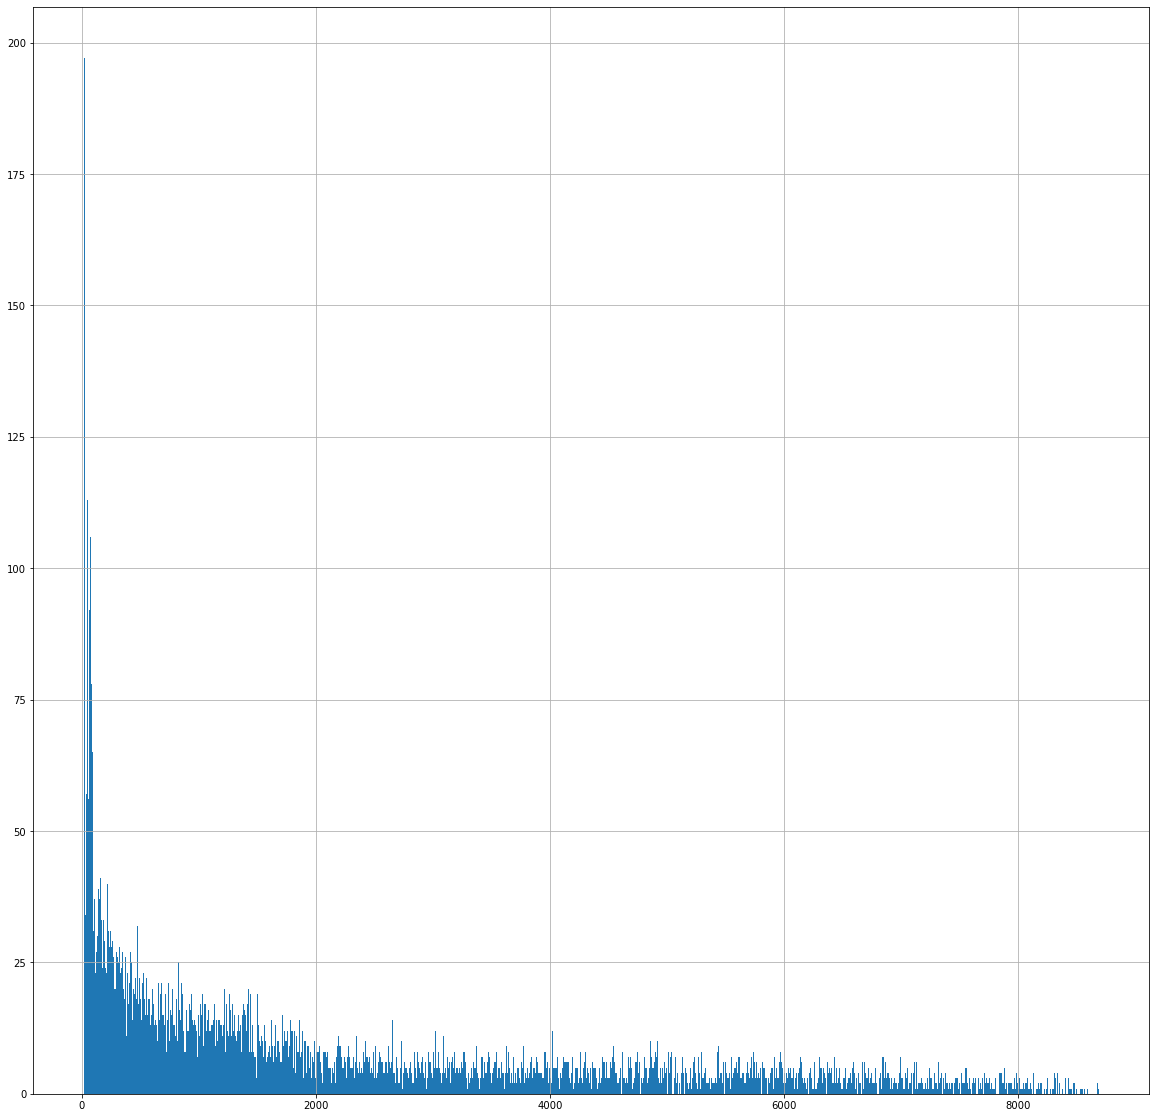

In [15]:
train.TotalCharges.hist(figsize = (20,20), bins = 1000)

### Categorical Variables
The column consists of two categories only, Y and N. Let's explore further if we can order those or just one-hot encode them.

#### Note:
One hot encoding a feature adds new features for each unique category, so if you have only two catogries "Y" and "N" in Churn, you will have two new columns Y and N where Y feature will have 1s in the places diagnosis = "Y" and N feature will have 1's in the places diagnosis = "N"

#### Example

One-hot encoding:

diagnosis &nbsp;&nbsp;&nbsp; Y | N <br>
Y &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;         1 | 0 <br>
N &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;         0 | 1 <br>
N &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;         0 | 1 <br>
Y &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;         1 | 0 <br>
Y &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;         1 | 0 <br>

Label encoding: if Y is ranked lower than N: <br>
diagnosis  &nbsp;    diagnosis_new <br>
Y  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;            1 <br>
N  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;            2 <br>
N  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;            2 <br>
Y  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;            1 <br>
Y  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;            1 <br>


But how can we really know if the data is ranked or not? This can be done using dommain knowledge of the data, for example most of the features are described in the main dataset page, You can also determine this in real life problems using your own knowledge of the problem and the data collected.
Here in this data it is obvious that Y means the customer left and N means still a customer, also note that Churn is the target variable so I will go for label encoding the variable to get one output for each row.

In [16]:
from sklearn import preprocessing

label_enc = preprocessing.LabelEncoder()
train.Churn = label_enc.fit_transform(train.Churn)
labels = train.Churn

In [17]:
label_enc.classes_

array(['No', 'Yes'], dtype=object)

In [18]:
train[['Female', 'Male']] = pd.get_dummies(train.gender)

In [19]:
train[['part_n', 'part_y']] = pd.get_dummies(train.Partner)
train[['dep_n', 'dep_y']] = pd.get_dummies(train.Dependents)
train[['phone_n', 'phone_y']] = pd.get_dummies(train.PhoneService)
train[['senior', 'not-senior']] = pd.get_dummies(train.SeniorCitizen)
train[['one_line', 'no_line', 'multi-line']] = pd.get_dummies(train.MultipleLines)
train[['bt' ,'cc', 'ec', 'mc']] = pd.get_dummies(train.PaymentMethod)
train[['mm' ,'oy', 'ty']] = pd.get_dummies(train.Contract)

In [20]:
train

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,one_line,no_line,multi-line,bt,cc,ec,mc,mm,oy,ty
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,0,1,0,0,0,1,0,1,0,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,1,0,0,0,0,0,1,0,1,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,1,0,0,0,0,0,1,1,0,0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,0,1,0,1,0,0,0,0,1,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,1,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,0,0,1,0,0,0,1,0,1,0
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,0,0,1,0,1,0,0,0,1,0
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,0,1,0,0,0,1,0,1,0,0
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,0,0,1,0,0,0,1,1,0,0


In [21]:
NUM_COLS = list(train.dtypes[train.dtypes != 'object'].index)

In [22]:
NUM_COLS

['SeniorCitizen',
 'tenure',
 'MonthlyCharges',
 'TotalCharges',
 'Churn',
 'Female',
 'Male',
 'part_n',
 'part_y',
 'dep_n',
 'dep_y',
 'phone_n',
 'phone_y',
 'senior',
 'not-senior',
 'one_line',
 'no_line',
 'multi-line',
 'bt',
 'cc',
 'ec',
 'mc',
 'mm',
 'oy',
 'ty']

In [23]:
train_new = train[NUM_COLS].drop(['Churn'], axis = 1)

In [24]:
train_new

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Female,Male,part_n,part_y,dep_n,dep_y,...,one_line,no_line,multi-line,bt,cc,ec,mc,mm,oy,ty
0,0,1,29.85,29.85,1,0,0,1,1,0,...,0,1,0,0,0,1,0,1,0,0
1,0,34,56.95,1889.50,0,1,1,0,1,0,...,1,0,0,0,0,0,1,0,1,0
2,0,2,53.85,108.15,0,1,1,0,1,0,...,1,0,0,0,0,0,1,1,0,0
3,0,45,42.30,1840.75,0,1,1,0,1,0,...,0,1,0,1,0,0,0,0,1,0
4,0,2,70.70,151.65,1,0,1,0,1,0,...,1,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,24,84.80,1990.50,0,1,0,1,0,1,...,0,0,1,0,0,0,1,0,1,0
7039,0,72,103.20,7362.90,1,0,0,1,0,1,...,0,0,1,0,1,0,0,0,1,0
7040,0,11,29.60,346.45,1,0,0,1,0,1,...,0,1,0,0,0,1,0,1,0,0
7041,1,4,74.40,306.60,0,1,0,1,1,0,...,0,0,1,0,0,0,1,1,0,0


### Feature Selection

Lets now see if the new features we added have any segnificance for the extra tee model or not and how important are our features. We can check that through the Extra trees algorithm which can predict the useful features internally usign "feature_importances"

In [25]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split( train_new.values, labels.values, test_size = 0.2, random_state=42 )

<AxesSubplot:>

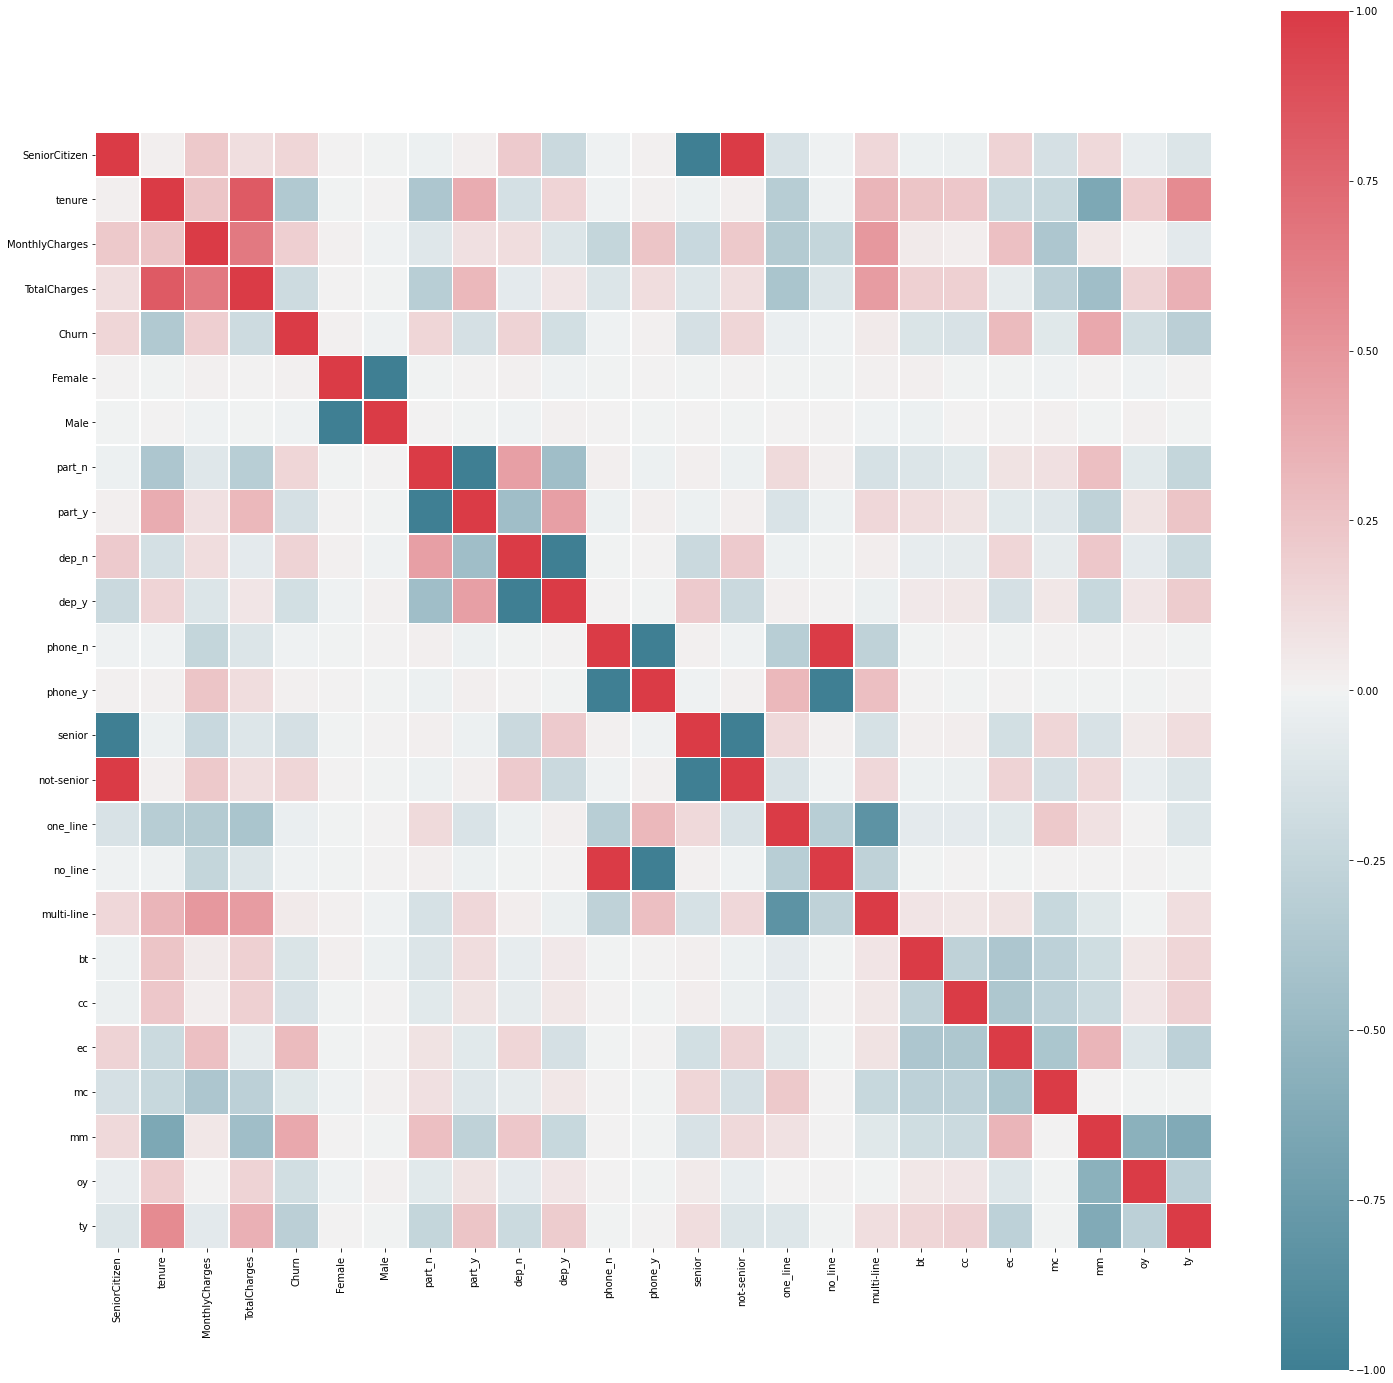

In [26]:
import seaborn as sns


import matplotlib.pyplot as plt


corr = train.corr()
f, ax = plt.subplots(figsize=(25, 25))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=1, vmin = -1, center=0,
            square=True, linewidths=.5)

In [27]:
from sklearn import datasets
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
# load the iris datasets
dataset = datasets.load_iris()
# fit an Extra Trees model to the data
clf = ExtraTreesClassifier()
clf.fit(x_train,y_train)
# display the relative importance of each attribute
z = clf.feature_importances_
#make a dataframe to display every value and its column name
df = pd.DataFrame()
print(len(z))
print(len(list(train_new.columns.values)))

df["values"] = z
df['column'] = list(train_new.columns.values)
# Sort then descendingly to get the worst features at the end
df.sort_values(by='values', ascending=False, inplace = True)
df.head(100)

24
24


,values,column
2,0.248455,MonthlyCharges
3,0.236212,TotalCharges
1,0.203539,tenure
21,0.072218,mm
19,0.041593,ec
23,0.029801,ty
22,0.018032,oy
4,0.013273,Female
5,0.012962,Male
7,0.012370,part_y


In [28]:
train.gender.value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

<AxesSubplot:xlabel='gender'>

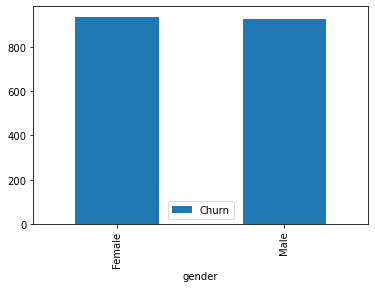

In [29]:
train[['Churn', 'gender']].groupby('gender').sum().plot(kind = 'bar')

In [30]:
# SelectKBest selects features according to the k highest scores of a given scoring function 
from sklearn.feature_selection import SelectKBest # This models a statistical test known as ANOVA 
from sklearn.feature_selection import f_classif

k_best = SelectKBest(f_classif, k = 10)
k_best.fit_transform( x_train, y_train)

array([[2.10000e+01, 6.48500e+01, 1.33680e+03, ..., 0.00000e+00,
        1.00000e+00, 0.00000e+00],
       [5.40000e+01, 9.72000e+01, 5.12945e+03, ..., 0.00000e+00,
        0.00000e+00, 1.00000e+00],
       [1.00000e+00, 2.34500e+01, 2.34500e+01, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [1.20000e+01, 2.11500e+01, 3.06050e+02, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.20000e+01, 9.94500e+01, 1.20015e+03, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       [2.60000e+01, 1.98000e+01, 4.57300e+02, ..., 0.00000e+00,
        1.00000e+00, 0.00000e+00]])

In [31]:
k_best.pvalues_ 
p_values = pd.DataFrame({'column': train_new.columns, 'p_value': k_best.pvalues_})
p_values.sort_values('p_value')
p_values

,column,p_value
0,SeniorCitizen,1.288715e-28
1,tenure,3.780534e-157
2,MonthlyCharges,2.936101e-46
3,TotalCharges,2.319791e-49
4,Female,3.787300e-01
5,Male,3.787300e-01
6,part_n,7.301336e-27
7,part_y,7.301336e-27
8,dep_n,1.392328e-34
9,dep_y,1.392328e-34


From the hypothesis testing, the correlations and the model based feature selection we can conclude that the gender feature doesn't have a segnificant effect of the Churn feature. And it is also obvious that the Teneor and MonthlyCharges are the most important features from our analysis based on the above analysis.

In [32]:
from mlxtend.classifier import StackingCVClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import  GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets
from sklearn import metrics
from sklearn import ensemble,model_selection,svm
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

c1 = ExtraTreesClassifier(n_estimators=700,bootstrap=True) 
meta2 = ExtraTreesClassifier(n_estimators=200,bootstrap=True) 

c2 = RandomForestClassifier(n_estimators=500,bootstrap=True)
c3 = XGBClassifier()
c4 = svm.LinearSVC()
c5 = GradientBoostingClassifier()
c6 = AdaBoostClassifier()
meta = LogisticRegression()

etc = StackingCVClassifier(classifiers=[c1, c2, c3, meta, c5],use_probas=True,meta_classifier=meta2)

etc.fit(x_train, y_train)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:53:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:53:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:53:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


StackingCVClassifier(classifiers=[ExtraTreesClassifier(bootstrap=True,
                                                       n_estimators=700),
                                  RandomForestClassifier(n_estimators=500),
                                  XGBClassifier(base_score=None, booster=None,
                                                colsample_bylevel=None,
                                                colsample_bynode=None,
                                                colsample_bytree=None,
                                                gamma=None, gpu_id=None,
                                                importance_type='gain',
                                                interaction_constraints=None,
                                                learning_rate=None,
                                                max_delta_step=No...
                                                monotone_constraints=None,
                                                n_e

In [33]:
print('Accuracy of classifier on training set: {:.2f}'.format(etc.score(x_train, y_train) * 100))
print('Accuracy of classifier on test set: {:.2f}'.format(etc.score(x_test, y_test) * 100))

Accuracy of classifier on training set: 82.32
Accuracy of classifier on test set: 79.84


In [34]:
from xgboost import XGBClassifier

def objective(trial,data=train_new.values,target=labels.values):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15,random_state=42)
    
    param = {
        'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': trial.suggest_int('n_estimators', 100, 4000, 100),
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
        'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
    }
    
    model = XGBClassifier(**param)  
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
    preds = model.predict(test_x)
    acc = accuracy_score(test_y, preds)
    return acc


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2021-04-04 19:53:52,200] A new study created in memory with name: no-name-3c735926-83ee-402c-8e75-bdef314793fe
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:53:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:54:00,049] Trial 0 finished with value: 0.7899716177861873 and parameters: {'lambda': 0.17556217092467613, 'alpha': 0.008349889152164364, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.016, 'n_estimators': 3800, 'max_depth': 17, 'random_state': 24}. Best is trial 0 with value: 0.7899716177861873.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:54:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:54:12,568] Trial 1 finished with value: 0.7975402081362346 and parameters: {'lambda': 0.07996034150169579, 'alpha': 0.003683607745080671, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.009, 'n_estimators': 1700, 'max_depth': 15, 'random_state': 2020}. Best is trial 1 with value: 0.7975402081362346.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:54:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:54:17,639] Trial 2 finished with value: 0.7994323557237465 and parameters: {'lambda': 0.040262948918608064, 'alpha': 0.0012222256094757621, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.02, 'n_estimators': 1100, 'max_depth': 17, 'random_state': 48}. Best is trial 2 with value: 0.7994323557237465.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:54:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:54:23,536] Trial 3 finished with value: 0.7947019867549668 and parameters: {'lambda': 1.2606171440284542, 'alpha': 2.1688663160249146, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'n_estimators': 400, 'max_depth': 17, 'random_state': 24}. Best is trial 2 with value: 0.7994323557237465.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:54:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:54:34,903] Trial 4 finished with value: 0.7918637653736992 and parameters: {'lambda': 0.02809163823117507, 'alpha': 0.16585134638784294, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.009, 'n_estimators': 1200, 'max_depth': 13, 'random_state': 48}. Best is trial 2 with value: 0.7994323557237465.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:54:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:54:40,469] Trial 5 finished with value: 0.7947019867549668 and parameters: {'lambda': 3.5877595927795527, 'alpha': 0.01060140687754883, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.018, 'n_estimators': 1400, 'max_depth': 15, 'random_state': 24}. Best is trial 2 with value: 0.7994323557237465.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:54:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:54:50,082] Trial 6 finished with value: 0.7947019867549668 and parameters: {'lambda': 0.10837939447379062, 'alpha': 0.1584722553961258, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.008, 'n_estimators': 2600, 'max_depth': 13, 'random_state': 2020}. Best is trial 2 with value: 0.7994323557237465.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:54:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:54:54,459] Trial 7 finished with value: 0.7965941343424787 and parameters: {'lambda': 1.8853919735651088, 'alpha': 0.1654625897270439, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.02, 'n_estimators': 2600, 'max_depth': 11, 'random_state': 24}. Best is trial 2 with value: 0.7994323557237465.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:54:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:54:55,685] Trial 8 finished with value: 0.8022705771050141 and parameters: {'lambda': 0.014496637278284347, 'alpha': 0.5295401335600912, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.009, 'n_estimators': 500, 'max_depth': 5, 'random_state': 24}. Best is trial 8 with value: 0.8022705771050141.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:54:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:55:09,866] Trial 9 finished with value: 0.7965941343424787 and parameters: {'lambda': 0.07519859845791607, 'alpha': 0.0011172712008730545, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.008, 'n_estimators': 1700, 'max_depth': 13, 'random_state': 2020}. Best is trial 8 with value: 0.8022705771050141.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:55:10,108] Trial 10 finished with value: 0.7965941343424787 and parameters: {'lambda': 0.0010415324268714906, 'alpha': 3.0182655359322736, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.014, 'n_estimators': 100, 'max_depth': 5, 'random_state': 24}. Best is trial 8 with value: 0.8022705771050141.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:55:13,167] Trial 11 finished with value: 0.8032166508987701 and parameters: {'lambda': 0.004777749560736513, 'alpha': 1.304670168457876, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 700, 'max_depth': 7, 'random_state': 48}. Best is trial 11 with value: 0.8032166508987701.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:55:15,993] Trial 12 finished with value: 0.7994323557237465 and parameters: {'lambda': 0.0028517266389857495, 'alpha': 0.8115770260536281, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 600, 'max_depth': 7, 'random_state': 48}. Best is trial 11 with value: 0.8032166508987701.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:55:24,398] Trial 13 finished with value: 0.7965941343424787 and parameters: {'lambda': 0.0064972250973818965, 'alpha': 0.9367337264745763, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.012, 'n_estimators': 700, 'max_depth': 20, 'random_state': 48}. Best is trial 11 with value: 0.8032166508987701.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:55:24,752] Trial 14 finished with value: 0.7852412488174078 and parameters: {'lambda': 0.009687869599741748, 'alpha': 8.485132789224826, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.01, 'n_estimators': 100, 'max_depth': 9, 'random_state': 48}. Best is trial 11 with value: 0.8032166508987701.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:55:26,844] Trial 15 finished with value: 0.804162724692526 and parameters: {'lambda': 0.0011567366754937714, 'alpha': 0.04057422501210988, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.009, 'n_estimators': 2400, 'max_depth': 5, 'random_state': 24}. Best is trial 15 with value: 0.804162724692526.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:55:30,445] Trial 16 finished with value: 0.7984862819299905 and parameters: {'lambda': 0.0011639729565737016, 'alpha': 0.04012905077989776, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 2600, 'max_depth': 7, 'random_state': 48}. Best is trial 15 with value: 0.804162724692526.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:55:31,679] Trial 17 finished with value: 0.8032166508987701 and parameters: {'lambda': 0.0028485670954752416, 'alpha': 0.036032725055930595, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.016, 'n_estimators': 3500, 'max_depth': 5, 'random_state': 24}. Best is trial 15 with value: 0.804162724692526.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:55:33,148] Trial 18 finished with value: 0.8088930936613056 and parameters: {'lambda': 0.001960795982832444, 'alpha': 0.03794511911176965, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.016, 'n_estimators': 4000, 'max_depth': 5, 'random_state': 24}. Best is trial 18 with value: 0.8088930936613056.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:55:34,647] Trial 19 finished with value: 0.8032166508987701 and parameters: {'lambda': 0.0011758387643306758, 'alpha': 0.0299586276168526, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.016, 'n_estimators': 3300, 'max_depth': 5, 'random_state': 24}. Best is trial 18 with value: 0.8088930936613056.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:55:36,470] Trial 20 finished with value: 0.8079470198675497 and parameters: {'lambda': 0.0022942534598005687, 'alpha': 0.06536464944987275, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.014, 'n_estimators': 4000, 'max_depth': 5, 'random_state': 24}. Best is trial 18 with value: 0.8088930936613056.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:55:37,931] Trial 21 finished with value: 0.8070009460737938 and parameters: {'lambda': 0.0023199453272239783, 'alpha': 0.0680378749886497, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.014, 'n_estimators': 4000, 'max_depth': 5, 'random_state': 24}. Best is trial 18 with value: 0.8088930936613056.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:55:39,398] Trial 22 finished with value: 0.8060548722800378 and parameters: {'lambda': 0.002726434633980015, 'alpha': 0.012530215111256822, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.014, 'n_estimators': 4000, 'max_depth': 5, 'random_state': 24}. Best is trial 18 with value: 0.8088930936613056.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:55:40,855] Trial 23 finished with value: 0.804162724692526 and parameters: {'lambda': 0.3019536639480813, 'alpha': 0.08322726170091384, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.014, 'n_estimators': 3200, 'max_depth': 5, 'random_state': 24}. Best is trial 18 with value: 0.8088930936613056.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:55:42,292] Trial 24 finished with value: 0.8032166508987701 and parameters: {'lambda': 0.02175919461835102, 'alpha': 0.3389913797158281, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.014, 'n_estimators': 4000, 'max_depth': 5, 'random_state': 24}. Best is trial 18 with value: 0.8088930936613056.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:55:45,306] Trial 25 finished with value: 0.793755912961211 and parameters: {'lambda': 0.003080267536713467, 'alpha': 0.0872926433220305, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.014, 'n_estimators': 3600, 'max_depth': 9, 'random_state': 24}. Best is trial 18 with value: 0.8088930936613056.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:55:49,555] Trial 26 finished with value: 0.793755912961211 and parameters: {'lambda': 0.009548637381424842, 'alpha': 0.0043320881535714294, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.014, 'n_estimators': 3000, 'max_depth': 11, 'random_state': 24}. Best is trial 18 with value: 0.8088930936613056.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:55:55,706] Trial 27 finished with value: 0.7994323557237465 and parameters: {'lambda': 0.0016601478122988803, 'alpha': 0.019901245801380408, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.016, 'n_estimators': 4000, 'max_depth': 20, 'random_state': 24}. Best is trial 18 with value: 0.8088930936613056.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:55:57,691] Trial 28 finished with value: 0.8079470198675497 and parameters: {'lambda': 0.006350029480998821, 'alpha': 0.06085111768051286, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.012, 'n_estimators': 3600, 'max_depth': 5, 'random_state': 2020}. Best is trial 18 with value: 0.8088930936613056.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:55:59,315] Trial 29 finished with value: 0.8070009460737938 and parameters: {'lambda': 0.0055492171941231416, 'alpha': 0.004828951363162776, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.012, 'n_estimators': 3700, 'max_depth': 5, 'random_state': 2020}. Best is trial 18 with value: 0.8088930936613056.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:56:01,116] Trial 30 finished with value: 0.8051087984862819 and parameters: {'lambda': 0.013590257041066922, 'alpha': 0.2997104190589605, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.012, 'n_estimators': 3100, 'max_depth': 5, 'random_state': 2020}. Best is trial 18 with value: 0.8088930936613056.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:56:02,742] Trial 31 finished with value: 0.8051087984862819 and parameters: {'lambda': 0.0018902524534212132, 'alpha': 0.058522901180556544, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.012, 'n_estimators': 3800, 'max_depth': 5, 'random_state': 2020}. Best is trial 18 with value: 0.8088930936613056.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:56:04,412] Trial 32 finished with value: 0.8070009460737938 and parameters: {'lambda': 0.005796387499271983, 'alpha': 0.005152514918751162, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.012, 'n_estimators': 3700, 'max_depth': 5, 'random_state': 2020}. Best is trial 18 with value: 0.8088930936613056.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:56:12,760] Trial 33 finished with value: 0.7871333964049196 and parameters: {'lambda': 0.0018979442683550397, 'alpha': 0.019244048665429597, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.016, 'n_estimators': 3400, 'max_depth': 15, 'random_state': 2020}. Best is trial 18 with value: 0.8088930936613056.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:56:23,115] Trial 34 finished with value: 0.7880794701986755 and parameters: {'lambda': 0.3034579052709416, 'alpha': 0.06913788271159636, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.014, 'n_estimators': 4000, 'max_depth': 17, 'random_state': 24}. Best is trial 18 with value: 0.8088930936613056.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:56:24,235] Trial 35 finished with value: 0.8060548722800378 and parameters: {'lambda': 0.004440171431835955, 'alpha': 0.13449721910283, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.02, 'n_estimators': 2900, 'max_depth': 5, 'random_state': 24}. Best is trial 18 with value: 0.8088930936613056.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:56:25,870] Trial 36 finished with value: 0.8088930936613056 and parameters: {'lambda': 0.02916659502558322, 'alpha': 0.002656768519191507, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.012, 'n_estimators': 3700, 'max_depth': 5, 'random_state': 2020}. Best is trial 18 with value: 0.8088930936613056.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:56:33,271] Trial 37 finished with value: 0.8022705771050141 and parameters: {'lambda': 0.040329646343948214, 'alpha': 0.002022518652661729, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.012, 'n_estimators': 3500, 'max_depth': 17, 'random_state': 2020}. Best is trial 18 with value: 0.8088930936613056.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:56:37,081] Trial 38 finished with value: 0.7947019867549668 and parameters: {'lambda': 0.05564732159492567, 'alpha': 0.002778648020682619, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.018, 'n_estimators': 3800, 'max_depth': 11, 'random_state': 2020}. Best is trial 18 with value: 0.8088930936613056.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:56:47,193] Trial 39 finished with value: 0.793755912961211 and parameters: {'lambda': 0.02114297626734831, 'alpha': 0.0073826149704819865, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.012, 'n_estimators': 2800, 'max_depth': 15, 'random_state': 2020}. Best is trial 18 with value: 0.8088930936613056.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:56:52,131] Trial 40 finished with value: 0.793755912961211 and parameters: {'lambda': 0.15364603613612735, 'alpha': 0.3189810902882446, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.016, 'n_estimators': 2100, 'max_depth': 13, 'random_state': 2020}. Best is trial 18 with value: 0.8088930936613056.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:56:53,921] Trial 41 finished with value: 0.8088930936613056 and parameters: {'lambda': 0.009336784184677618, 'alpha': 0.001706513277495656, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.012, 'n_estimators': 3700, 'max_depth': 5, 'random_state': 2020}. Best is trial 18 with value: 0.8088930936613056.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:56:55,560] Trial 42 finished with value: 0.8088930936613056 and parameters: {'lambda': 0.009615566398363239, 'alpha': 0.0016631484547633844, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.012, 'n_estimators': 3300, 'max_depth': 5, 'random_state': 2020}. Best is trial 18 with value: 0.8088930936613056.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:56:57,138] Trial 43 finished with value: 0.8088930936613056 and parameters: {'lambda': 0.011084723158121298, 'alpha': 0.0017889590634382303, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.012, 'n_estimators': 3300, 'max_depth': 5, 'random_state': 2020}. Best is trial 18 with value: 0.8088930936613056.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:56:59,020] Trial 44 finished with value: 0.8051087984862819 and parameters: {'lambda': 0.03731367434264098, 'alpha': 0.0018199571157254072, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.012, 'n_estimators': 3200, 'max_depth': 5, 'random_state': 2020}. Best is trial 18 with value: 0.8088930936613056.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:57:00,725] Trial 45 finished with value: 0.8070009460737938 and parameters: {'lambda': 0.01354802790892684, 'alpha': 0.0011976440261189582, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.012, 'n_estimators': 3400, 'max_depth': 5, 'random_state': 2020}. Best is trial 18 with value: 0.8088930936613056.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:57:14,887] Trial 46 finished with value: 0.793755912961211 and parameters: {'lambda': 0.02428162447908634, 'alpha': 0.0019513821205005735, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.008, 'n_estimators': 3800, 'max_depth': 20, 'random_state': 2020}. Best is trial 18 with value: 0.8088930936613056.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:57:18,606] Trial 47 finished with value: 0.7956480605487228 and parameters: {'lambda': 0.009757540221979158, 'alpha': 0.0010001209131479448, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.012, 'n_estimators': 2800, 'max_depth': 9, 'random_state': 2020}. Best is trial 18 with value: 0.8088930936613056.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:57:20,406] Trial 48 finished with value: 0.8079470198675497 and parameters: {'lambda': 0.0570274914657157, 'alpha': 0.002889305536734466, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.012, 'n_estimators': 2300, 'max_depth': 5, 'random_state': 2020}. Best is trial 18 with value: 0.8088930936613056.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-04 19:57:27,165] Trial 49 finished with value: 0.7899716177861873 and parameters: {'lambda': 0.01737068080431038, 'alpha': 0.001535502273207302, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'n_estimators': 1700, 'max_depth': 13, 'random_state': 2020}. Best is trial 18 with value: 0.8088930936613056.


Number of finished trials: 50
Best trial: {'lambda': 0.001960795982832444, 'alpha': 0.03794511911176965, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.016, 'n_estimators': 4000, 'max_depth': 5, 'random_state': 24}


In [35]:
param = {'lambda': 0.019097303955226335, 'alpha': 6.255501364107075, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.018, 'n_estimators': 3000, 'max_depth': 5, 'random_state': 24}

In [36]:
clf = XGBClassifier(**param)

clf.fit(x_train, y_train)

print('Accuracy of classifier on training set: {:.2f}'.format(clf.score(x_train, y_train) * 100))
print('Accuracy of classifier on test set: {:.2f}'.format(clf.score(x_test, y_test) * 100))

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of classifier on training set: 84.59
Accuracy of classifier on test set: 80.34
